# Ray Paths

## Name:

## Date: 

In [1]:
from numpy import sqrt
from numpy import log
from numpy import linspace
from numpy import zeros
from numpy import asarray

def layerxt(p, h, vtop, vbottom):
    """
    Calcualtes the change in position and change in time for a ray in a layer with a linear
    velocity gradient.  This is a Python translation of Shearer's layerxt which was heavily
    modified from a portion of Chris Chapman's WKBJ program.
    
    Input
    -----
    p : float
        Horizontal slowness (s/km).
    h : float
        Layer thickness (km).
    vtop : float
        Velocity (km/s) at the top of the layer.
    vbottom : float
        Velocity (km/s) at the bottom of the layer.
        
    Returns
    -------
    dx : float
         Range offset (km).
    dt : float
         Travel time change (seconds).    
    irtr : integer
        This is a return code that can mean:
          -1 -> zero thickness layer.
           0 -> ray turned above the layer.
           1 -> ray passed through the layer.
           2 -> ray turned in the layer and only one leg in the dx and dt is counted.
    
    """
    # Checks
    irtr =-1
    dx = None
    dt = None
    if (h < 0.0):
        print("Layer thickness cannot be negative")
        return dx, dt, irtr
    if (vtop <= 0.0 or vbottom <= 0.0):
        print("Velocities must be positive")
        return dx, dt, irtr
    # Compute slownesses
    u1 = 1.0/vtop    # Slowness at top of layer
    u2 = 1.0/vbottom # Slowness at bottom of layer
    dx = 0.0
    dt = 0.0
    # Ray turned above this layer
    if (p >= u1):
        irtr = 0
        return dx, dt, irtr
    # Zero layer thickness
    if (h == 0):
        irtr = -1
        return dx, dt, irtr
    b = (vtop - vbottom)/h # Velocity gradient; Eqn 4.20 of Shearer
    eta1 = sqrt(u1**2 - p**2)

    # Constant velocity layer - ray must pass through
    if (abs(b) == 0.0):
        dx = h*p/eta1
        dt = h*u1**2/eta1
        irtr = 1
        return dx, dt, irtr
    
    x1 = eta1/(u1*b*p) # Eqn 4.21 of Shearer
    tau1 = (log((u1 + eta1)/p) - eta1/u1)/b # Eqn 4.22 of Shearer
    # Ray turns within layer - no contribution to integral from bottom point
    # Ray turned in the layer
    if (p >= u2):
        dx = x1
        dtau = tau1
        dt = dtau + p*dx
        irtr = 2
        return dx, dt, irtr

    # Ray passed through the layer
    irtr = 1
    eta2 = sqrt(u2**2 - p**2)
    x2 = eta2/(u2*b*p) # Eqn 4.21 of Shearer
    tau2 = (log((u2 + eta2)/p) - eta2/u2)/b # Eqn 4.22 of Shearer

    dx = x1 - x2
    dtau = tau1 - tau2

    dt = dtau + p*dx
    
    return dx, dt, irtr


In [95]:
def computeXTInLayeredGradientModel(rayParameters, deps, vp, redvel = 8.0):
    """
    Computes the travel-time distance in a layered model where each model
    consists of velocity gradients.  Here, the structural models increase
    positively with depth.
    
    Input
    -----
    rayParameters : array_like
        Apparent slownesses (s/km)
    deps : array_like
        Depth to each interface (km).  Note, there are len(h) - 1 layers and each
        layer thickness is h[layer+1] - h[layer].  
    vp : array_like
        Compressional velocity (km/s) at the layer interfaces.
    redvel : float
        Reduction velocity (km/s).  Shearer uses 8 km/s in the HW.
    
    Returns
    -------
    offset : array_like
        The offsets in x (km), i.e, distance traveled for each ray parameter.
    ttimes : array_like
        The redued travel times (s) for each ray parameter.
    
    Copyright
    ---------
    Ben Baker distributed under the MIT license.
    
    """
    # Loop on ray parameters
    xtimes = zeros(len(rayParameters))
    ttimes = zeros(len(rayParameters))
    for ip in range(len(rayParameters)):
        # Loop on model depths
        x = 0.0 # Offset
        t = 0.0 # Travel time
        p = rayParameters[ip] # Ray parameter
        for depth in range(len(deps)-1):
            h = deps[depth+1] - deps[depth]
            vtop    = vp[depth]
            vbottom = vp[depth+1]
            dx, dt, irtr = layerxt(p, h, vtop, vbottom)
            # Typically the ray continues through the layer
            if (irtr == 1):
                x = x + dx*2.0 # Up and downgoing leg
                t = t + dt*2.0 # Up and downgoing leg
            elif (irtr == 2):
                x = x + dx*2.0 # Up and downgoing leg
                t = t + dt*2.0 # Up and downgoing leg
                break
            # Ray turned in layer above - stop calculating (I should hit this)
            if (irtr == 0):
                break
        # Loop on depths
        xtimes[ip] = x # Tabulate distance
        ttimes[ip] = t # Tabulate time
    # Loop on ray parameters
    #TODO - Something screwy - but x and t are negative.  I need to implement from Chapman's book
    offset =-xtimes # Make xtimes positive
    ttimes =-ttimes
    if (redvel > 0.0):
        reducedTimes = ttimes - offset/redvel # Reduce travel times with reduction velocity
    else:
        reducedTimes = ttimes
    return offset, reducedTimes


Compute the P-wave traveltime, $T(X)$ curve for the velocity model

| Depth (km)  | $\alpha$ (km/s) | $\beta$ (km/s)  | $\rho$ (g/cm^3) |
| ----------- |-------------:| -----:|----:|
| 0.0         | 4.50         | 2.40  | 2.0 |
| 1.5         | 6.80         | 3.75  | 2.8 |
| 6.0         | 7.00         | 3.85  | 2.9 |
| 6.5         | 8.00         | 4.60  | 3.1 |
| 10.0        | 8.10         | 4.70  | 3.1 |

for $100$ ray parameters from $0.1236$ s/km to $0.2217$ s/km.  Use a reduction velocity of $8$ km/s.

As a hint, your function call should look something like:

    offset, ttimes = computeXTInLayeredGradientModel(rayParameters, deps, velocities, redvel)

There should be about 3 to 4 lines of code and one of those lines should include linspace.

In [99]:
deps = [0.0, 1.5,  6.0,  6.5, 10.0] # Layer interfaces
vp   = [4.5, 6.8,  7.0,  8.0, 8.1]  # Compresional velocity (km/s)
vs   = [2.4, 3.75, 3.85, 4.6, 4.7]  # Shear velocity (km/s)
rho  = [2.0, 2.8,  2.9,  3.1, 3.1]  # Denisty (gm/cm**3) 
redvel = 8.0  # Reduction velocity (km/s).  This trick increases resolution curve.
pmin = 0.1236 # Minimum slowness in x (s/km)
pmax = 0.2217 # Maximum slowness in x (s/km)
np = 100 # Number of ray parameters
rayParameters = linspace(pmin, pmax, np)
offset, ttimes = computeXTInLayeredGradientModel(rayParameters, deps, vp, redvel)



## Question

Caustics are where $\frac{dp}{dx} = \infty$.  Given this, plot a travel-time vs. offset curve from distance $0$ to $\max\{offset\}$ and identify the offsets at which the caustics are located.


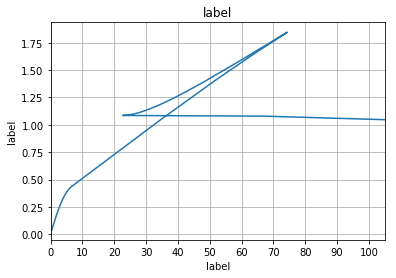

In [106]:
import matplotlib.pyplot as plt
plt.plot(offset, ttimes)
plt.ylabel('label')
plt.xlabel('label')
plt.title('label')
plt.xlim(0,max(offset))
#plt.ylim(0,2.0)
plt.xticks(linspace(0,100,11))
plt.grid(True)
plt.show()


## Question

We expect large amplitudes where rays are focused.  A way to identify an abundance of rays is to look at places where the change in ray parameter to the change in distance quickly changes to $0$ - i.e., places where the ray parameter/distance curve becomes flat.  At which distances would you expect the greatest amount of enregy to occur?  As a hint, don't pick ~72 km - though there is energy focusing here it won't be the most significant because the ray density will decrease as distance increases (this is a way to describe geometrical spreading). 

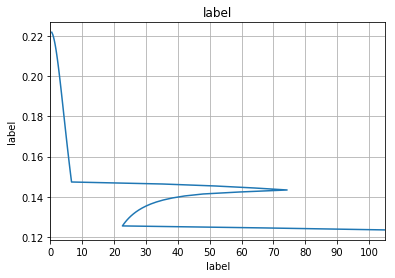

In [105]:
import matplotlib.pyplot as plt
plt.plot(offset, rayParameters)
plt.ylabel('label')
plt.xlabel('label')
plt.title('label')
plt.xlim(0,max(offset))
#plt.ylim(0,2.0)
plt.xticks(linspace(0,100,11))
plt.grid(True)
plt.show()